In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle/

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download clmentbisaillon/fake-and-real-news-dataset

 93% 38.0M/41.0M [00:00<00:00, 108MB/s] 
100% 41.0M/41.0M [00:00<00:00, 104MB/s]


In [6]:
! unzip fake-and-real-news-dataset


Archive:  fake-and-real-news-dataset.zip
  inflating: Fake.csv                
  inflating: True.csv                


In [7]:
import pandas as pd
True_dataset = pd.read_csv("True.csv")
Fake_dataset = pd.read_csv("Fake.csv")

In [ ]:
#TODO
#Podzielenie na treningowe i testowe (scikit)
#Dalsza obróbka danych (Preprocessing)
# Tokenizacja (rozbicie na mniejsze części)
# Lower case
# Usuwanie znaków specjalnych 
# Lemmatize/Stemming (Stemming np leaves -> leav  Lemmatize leaves -> leaf)
# Usuwanie stopwordów (np the/of/a/an itd)

In [8]:
True_dataset = pd.read_csv("True.csv")
True_dataset['value'] = 1

False_dataset = pd.read_csv("Fake.csv")
False_dataset['value'] = 0

In [ ]:
merged_dataset = pd.concat([True_dataset[:2500], False_dataset[:2500]], ignore_index=True)
merged_dataset

,title,text,subject,date,value
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1
...,...,...,...,...,...
4995,"WATCH: Fox News Host DEFENDS CNN Reporter, Te...",Even Fox News is calling Donald Trump out for ...,News,"February 16, 2017",0
4996,GOP Senator DESPERATELY Worried About Trump’s...,"On Thursday afternoon, the world was treated t...",News,"February 16, 2017",0
4997,WATCH: NBC Reporter Calls Trump Out For Lying...,Donald Trump finally held his first solo press...,News,"February 16, 2017",0
4998,Tapper SLAMS Trump For BIZARRE Behavior At ‘W...,There is certainly no love lost between CNN an...,News,"February 16, 2017",0


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(merged_dataset.iloc[:,:-1], merged_dataset.iloc[:,-1], test_size=0.2, random_state=42)

In [ ]:
import spacy

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
def tokenize_text(text):
    # Parse the text using SpaCy
    doc = nlp(text)
    # Extract tokens from the parsed document
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and not token.is_space and not token.like_num]
    return tokens

In [ ]:
X_train["tokenized_text"] = X_train["text"].apply(tokenize_text)

In [ ]:
# TODO
# TFIDF 
# Wprowadzić do SVM


In [ ]:
def join_text(text_list):
    return ' '.join(text_list)

In [ ]:
X_train['joined_tokenized_text'] = X_train['tokenized_text'].apply(join_text)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train['joined_tokenized_text'])

TfidfVectorizer()

In [ ]:
X = vectorizer.transform(X_train['joined_tokenized_text'])

In [ ]:
X_test["tokenized_text"] = X_test["text"].apply(tokenize_text)
X_test['joined_tokenized_text'] = X_test['tokenized_text'].apply(join_text)

In [ ]:
Z = vectorizer.transform(X_test['joined_tokenized_text'])

In [ ]:
from sklearn.svm import SVC

C controls the tradeoff between achieving a low training error and a low testing error. A smaller value of C creates a wider margin in the SVM classifier, which may lead to more training errors but better generalization to new, unseen data. A larger value of C creates a narrower margin, which may lead to fewer training errors but poorer generalization.

gamma controls the shape of the decision boundary. A smaller value of gamma produces a smoother, more generalized decision boundary, while a larger value of gamma produces a more complex, tighter decision boundary that may lead to overfitting.

Both hyperparameters should be tuned to find the optimal values that produce the best performance of the SVM model on the given dataset. This is typically done using techniques such as grid search, as we have done in the previous example.

In [ ]:
svm = SVC(C=1, gamma='scale')
svm.fit(X, y_train)

SVC(C=1)

In [ ]:
y_pred = svm.predict(Z)

In [ ]:
final = y_test.to_numpy()

In [ ]:
1- sum(abs(final - y_pred))/len(final)

0.994

In [ ]:
custom_fake_news = "Scientists have discovered a new vaccine that can cure cancer in just one week! This breakthrough is expected to save millions of lives and change the course of cancer treatment forever."
custom_fake_news_tokens = tokenize_text(custom_fake_news)
custom_fake_news_vector = vectorizer.transform([join_text(custom_fake_news_tokens)])

custom_fake_news_prediction = svm.predict(custom_fake_news_vector)

if custom_fake_news_prediction == 1:
    print("The SVM predicts that the custom news is real.")
else:
    print("The SVM predicts that the custom news is fake.")

The SVM predicts that the custom news is fake.


In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1, 1, 10, 100, 150], 'gamma': ['scale', 'auto']}
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X, y_train)

print("Best hyperparameters: ", grid_search.best_params_)
print("Best accuracy score: ", grid_search.best_score_)

Best hyperparameters:  {'C': 10, 'gamma': 'scale'}
Best accuracy score:  0.9924999999999999


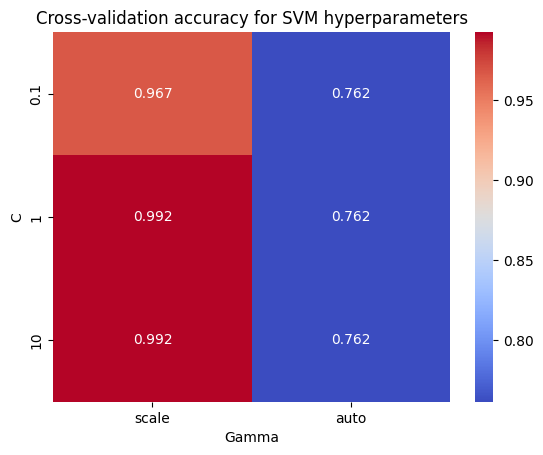

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

cv_results = grid_search.cv_results_
mean_scores = np.array(cv_results['mean_test_score']).reshape(3, 2)
sns.heatmap(mean_scores, xticklabels=['scale', 'auto'], yticklabels=[0.1, 1, 10], annot=True, cmap='coolwarm', fmt='.3f')

plt.xlabel('Gamma')
plt.ylabel('C')
plt.title('Cross-validation accuracy for SVM hyperparameters')
plt.show()

In [9]:
True_samples = [True_dataset[2501:2510]]
False_samples = [True_dataset[2501:2510]]